In [22]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import matplotlib.pyplot as plt

In [80]:
def rfft(x):
    x = (-1) ** np.array(x)
    return np.fft.rfft(x)[1:]
def manual_sr(x, N, shift=0):
    return sum(x[:, (i + shift) % N] + x[:, (i + 1 + shift) % N] for i in range(0, N, 4))
def generate_loss(gs, states=None, all=False):
    if not all and states:
        def weighted_loss(x, y):
            return torch.sum(abs(torch.tensor(gs.full()[states, :])) ** 2 * (x - y) ** 2)
        return weighted_loss
    else:
        def weighted_loss(x, y):
            return torch.sum(abs(torch.tensor(gs.full())) ** 2 * (x - y) ** 2)
        return weighted_loss

In [24]:
N=8; J1=1; J2=50.0
gs = qt.qload(f'../J1J2_info/large_J2/N{N}/n{N}gs_J2_50.0')
gs

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1]], shape=(256, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+000]
 [ 2.44006350e-046]
 [ 8.48489602e-019]
 [ 2.88424350e-018]
 [ 1.52592559e-018]
 [-6.26698055e-018]
 [-4.10048990e-018]
 [ 8.11909596e-018]
 [-1.08525363e-018]
 [-9.92445457e-018]
 [ 3.18499012e-018]
 [-2.70150670e-017]
 [ 1.47480396e-018]
 [ 1.26316768e-017]
 [-3.15441665e-017]
 [ 8.29151556e-002]
 [-1.73472348e-018]
 [ 8.67361738e-018]
 [-8.67361738e-019]
 [ 1.56563557e-017]
 [ 1.04083409e-017]
 [ 1.39420713e-017]
 [-6.23371219e-018]
 [ 4.17357009e-004]
 [ 8.67361738e-019]
 [ 1.84329593e-018]
 [ 6.00323805e-017]
 [-1.66665025e-001]
 [ 2.11067373e-017]
 [ 4.17357009e-004]
 [ 8.29151556e-002]
 [-1.69406589e-021]
 [-6.50521303e-019]
 [-3.03576608e-018]
 [-2.08166817e-017]
 [ 7.84730530e-017]
 [ 2.60208521e-018]
 [ 7.51035212e-018]
 [ 8.30831948e-017]
 [-1.66665025e-001]
 [-6.93889390e-018]
 [-2.38257804e-017]
 [ 6.91885261e-018]
 [-4.20176972

In [25]:
states, signs = utils.get_nonzero_states(N, gs, 1e-10)
input = utils.generate_input_samples(N, states)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)
print(ft_input.shape)
sign_label = torch.tensor(signs).reshape(-1, 1)
print(sign_label.shape)
sign_dataset = {'train_input':ft_input, 'train_label':sign_label, 'test_input':ft_input, 'test_label':sign_label}

torch.Size([70, 8])
torch.Size([70, 8])
torch.Size([70, 1])


In [35]:
kan_model = kan.KAN(width=[N, 1, 1])
kan_model.fit(sign_dataset, steps=50, lamb=1e-3, loss_fn = generate_loss(gs, states));

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.41e-03 | test_loss: 7.57e-03 | reg: 6.14e+00 | : 100%|█| 50/50 [00:05<00:00,  8.87it

saving model version 0.1


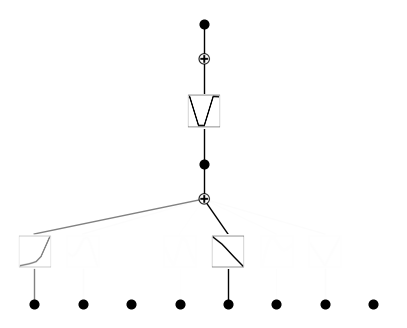

In [36]:
kan_model.plot()

In [37]:
kan_model.suggest_symbolic(1, 0, 0, weight_simple=0.3);

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       sin    0.999845 -12.561846           2                2   -8.193292
1       cos    0.999845 -12.561327           2                2   -8.192929
2  gaussian    0.999855 -12.658608           3                3   -7.961025
3     1/x^2    0.998708  -9.584801           2                2   -6.109361
4     1/x^4    0.996353  -8.095206           4                4   -4.466644


In [38]:
# kan_model.fix_symbolic(0, 0, 0, 'x');
kan_model.fix_symbolic(0, 4, 0, 'x');
kan_model.fix_symbolic(1, 0, 0, 'cos');

r2 is 0.995783269405365
saving model version 0.2
r2 is 0.9998445510864258
saving model version 0.3


In [ ]:
kan_model.fit(sign_dataset, steps=50, lamb=1e-3, loss_fn = generate_loss(gs, states=states));

| train_loss: 3.13e-03 | test_loss: 6.55e-03 | reg: 1.49e+00 | : 100%|█| 50/50 [00:08<00:00,  5.83it


saving model version 0.4


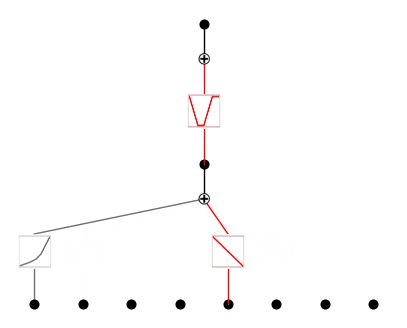

In [41]:
kan_model.plot()

In [42]:
kan_model.suggest_symbolic(0, 0, 0, weight_simple=0.3);

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^2    0.999402 -10.682902           2                2   -6.878032
1    1/x^3    0.999427 -10.744267           3                3   -6.620987
2      1/x    0.999200 -10.270403           2                2   -6.589282
3   arctan    0.999533 -11.033536           4                4   -6.523475
4      exp    0.999138 -10.163479           2                2   -6.514435


In [ ]:
kan_model.fix_symbolic(0, 0, 0, '1/x^2');
kan_model.fit(sign_dataset, steps=50, loss_fn=generate_loss(gs, states=states))

r2 is 0.9994016885757446
saving model version 0.5


| train_loss: 1.99e-04 | test_loss: 4.47e-04 | reg: 5.65e-01 | : 100%|█| 50/50 [00:06<00:00,  7.75it

saving model version 0.6


{'train_loss': [array(0.00210992),
  array(0.00126239),
  array(0.00097448),
  array(0.000959),
  array(0.00099254),
  array(0.00069359),
  array(0.00049171),
  array(0.00049382),
  array(0.00042691),
  array(0.00050947),
  array(0.00028343),
  array(0.00028388),
  array(0.00036332),
  array(0.00028039),
  array(0.00031671),
  array(0.00033354),
  array(0.00040098),
  array(0.000796),
  array(0.00031615),
  array(0.00028504),
  array(0.00069213),
  array(0.0003249),
  array(0.00036408),
  array(0.00024937),
  array(0.0003102),
  array(0.00040069),
  array(0.00029275),
  array(0.0003835),
  array(0.0001538),
  array(0.00050732),
  array(0.00023722),
  array(0.00025086),
  array(0.00026386),
  array(0.00034061),
  array(0.00037456),
  array(0.0003045),
  array(0.0003709),
  array(0.00036841),
  array(0.00016332),
  array(9.6693787e-05),
  array(0.00029489),
  array(0.00022618),
  array(0.00021391),
  array(0.0001044),
  array(0.00019466),
  array(0.00020222),
  array(0.00025234),
  array

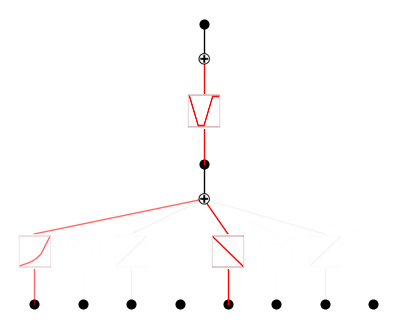

In [44]:
kan_model.plot()

In [45]:
ku.ex_round(kan_model.symbolic_formula()[0][0], 3)

c:\Users\taoha\anaconda3\envs\kans\lib\site-packages\sympy\core\sympify.py:475: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return sympify(float(a))


1.0*cos(6.169*x_5 + 7.348 - 4.482/(1.613 - 0.175*x_1)**2)

In [46]:
gs1 = qt.qload(f'../J1J2_info/large_J2/N{N}/n{N}gs_J2_1.0')

states, signs = utils.get_nonzero_states(N, gs1, 1e-10)
input = utils.generate_input_samples(N, states)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)
print(ft_input.shape)
sign_label1 = torch.tensor(signs).reshape(-1, 1)
print(sign_label1.shape)
sign_dataset1 = {'train_input':ft_input, 'train_label':sign_label, 'test_input':ft_input, 'test_label':sign_label}

torch.Size([70, 8])
torch.Size([70, 8])
torch.Size([70, 1])


In [ ]:
kan1 = kan.KAN(width=[N, 1, 1])
kan1.fit(sign_dataset1, steps=50, lamb=1e-3, loss_fn = generate_loss(gs1, states=states));

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.21e-03 | test_loss: 5.06e-03 | reg: 6.47e+00 | : 100%|█| 50/50 [00:05<00:00,  8.89it

saving model version 0.1


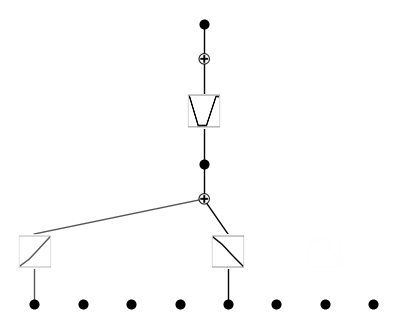

In [49]:
kan1.plot()


In [51]:
kan1.suggest_symbolic(1, 0, 0, weight_simple=0.5, topk=10);
kan1.suggest_symbolic(0, 0, 0, weight_simple=0.5, topk=10);
kan1.suggest_symbolic(0, 4, 0, weight_simple=0.5, topk=10);

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0  gaussian    0.999841 -12.534550           3                3   -4.767275
1     1/x^2    0.999453 -10.809285           2                2   -4.404642
2     1/x^4    0.999830 -12.443124           4                4   -4.221562
3       cos    0.999065 -10.047734           2                2   -4.023867
4       sin    0.999029  -9.992730           2                2   -3.996365
5       x^2    0.964276  -4.806569           2                2   -1.403285
6       abs    0.979668  -5.619367           3                3   -1.309683
7       tan    0.956715  -4.529663           3                3   -0.764832
8       x^4    0.897306  -3.283440           3                3   -0.141720
9         0    0.000000   0.000014           0                0    0.000007
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        cos    0.999921 -13.463003           2                2   -5.731501
1        s

In [52]:
kan1.fix_symbolic(1, 0, 0, 'cos');
kan1.fix_symbolic(0, 0, 0, 'x');
kan1.fix_symbolic(0, 4, 0, 'x');

r2 is 0.9990652203559875
saving model version 0.2
r2 is 0.9930309057235718
saving model version 0.3
r2 is 0.9964504837989807
saving model version 0.4


In [ ]:
kan1.fit(sign_dataset1, steps=50, lamb=1e-3, loss_fn = generate_loss(gs1, states=states));

| train_loss: 2.95e-03 | test_loss: 2.72e-03 | reg: 7.27e-02 | : 100%|█| 50/50 [00:08<00:00,  6.10it

saving model version 0.5


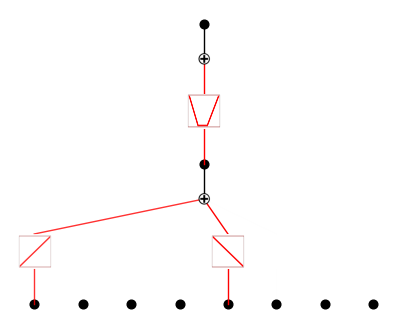

In [54]:
kan1.plot()

In [58]:
torch.sqrt((kan1(sign_dataset1['train_input']).round() - sign_dataset1['train_label'])**2).mean()

tensor(0., grad_fn=<MeanBackward0>)

In [59]:
ku.ex_round(kan1.symbolic_formula()[0][0], 4)

1.3409*cos(0.5998*x_1 - 1.4461*x_5 + 6.8284) - 0.2899

In [61]:
0.599/np.pi, 1.44/np.pi, 6.82/np.pi, 

(0.1906676218240906, 0.45836623610465854, 2.1708734237734526)

In [83]:
def get_nonzero_states(N, gs, threshold):
    states = []
    signs = []
    for i in range(0, 2**N):
        val = gs[i][0].real
        if abs(val) >= threshold:
            states.append(i)
            signs.append(-1 + 2 * int(val > 0))
    return states, signs

In [182]:
torch.manual_seed(0)
gs_inf = j1j2_functions.J1J2_hamiltonian(N, 0, 1).eigenstates()[1][0]
states_inf, signs_inf = get_nonzero_states(N, gs_inf, 0)

#input = utils.generate_input_samples(N, states_inf)
input = utils.generate_input_torch(N)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)
signs_inf = torch.tensor(signs_inf).reshape(-1, 1)

linear_layer = nn.Sequential(nn.Linear(N, 1))
opt = torch.optim.Adam(linear_layer.parameters(), lr=0.01, weight_decay=0)
floss = generate_loss(gs_inf, all=True)
epochs = 1000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.cos(linear_layer(ft_input))
        loss = torch.min(floss(pred, signs_inf), floss(pred, -1 * signs_inf))
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())

torch.Size([256, 8])
0.8843085805538319
0.0012329768918191398
0.0001538561577636679
4.434257255561371e-05
1.8035143307892906e-05


In [183]:
print(torch.sqrt((torch.cos(linear_layer(ft_input)) - signs_inf) ** 2).mean().item())
print(generate_loss(gs_inf, all=True)(torch.cos(linear_layer(ft_input)), signs_inf).item())

0.8934400677680969
8.859288523257702e-06


In [184]:
[n for n in linear_layer.parameters()]

[Parameter containing:
 tensor([[ 0.3659,  0.0226, -0.5949, -0.0148,  0.3585,  0.0244, -0.0070,  0.2803]],
        requires_grad=True),
 Parameter containing:
 tensor([0.2472], requires_grad=True)]

In [185]:
J2s = 1/ np.linspace(0 + 2 / 100, 2, 100)
J2s[:5]

array([50.        , 25.        , 16.66666667, 12.5       , 10.        ])

In [186]:
all_params = [[n.detach().clone() for n in linear_layer.parameters()]]
losses = [generate_loss(gs_inf, all=True)(torch.cos(linear_layer(ft_input)), signs_inf).item()]
for J2 in J2s:
    print('J2', J2)
    gs = qt.qload(f'../J1J2_info/large_J2/N{N}/n{N}gs_J2_{round(J2, 4)}')
    states, signs = get_nonzero_states(N, gs, 0)
    floss = generate_loss(gs, all=True)
    epochs = 200; datarate = epochs // 5

    for i in range(epochs):
        def closure():
            opt.zero_grad()
            pred = torch.cos(linear_layer(ft_input))
            loss = torch.min(floss(pred, signs_inf), floss(pred, -1 * signs_inf))
            loss.backward()
            return loss
        loss = opt.step(closure)
        #if i % datarate == 0:
        #    print(loss.item())
    
    all_params.append([n.detach().clone() for n in linear_layer.parameters()])
    pred = torch.cos(linear_layer(ft_input))
    losses.append(torch.min(floss(pred, signs_inf), floss(pred, -1 * signs_inf)).item())
    #print()

J2 50.0
J2 25.0
J2 16.666666666666668
J2 12.5
J2 10.0
J2 8.333333333333332
J2 7.142857142857143
J2 6.25
J2 5.555555555555555
J2 5.0
J2 4.545454545454546
J2 4.166666666666667
J2 3.846153846153846
J2 3.571428571428571
J2 3.333333333333333
J2 3.125
J2 2.941176470588235
J2 2.7777777777777772
J2 2.6315789473684212
J2 2.5
J2 2.380952380952381
J2 2.272727272727273
J2 2.1739130434782608
J2 2.083333333333333
J2 2.0
J2 1.923076923076923
J2 1.8518518518518516
J2 1.7857142857142856
J2 1.7241379310344827
J2 1.6666666666666667
J2 1.6129032258064517
J2 1.5625
J2 1.5151515151515151
J2 1.4705882352941175
J2 1.4285714285714284
J2 1.3888888888888886
J2 1.3513513513513513
J2 1.3157894736842106
J2 1.282051282051282
J2 1.25
J2 1.2195121951219512
J2 1.1904761904761905
J2 1.1627906976744187
J2 1.1363636363636365
J2 1.1111111111111112
J2 1.0869565217391304
J2 1.0638297872340425
J2 1.0416666666666665
J2 1.0204081632653061
J2 1.0
J2 0.9803921568627451
J2 0.9615384615384615
J2 0.9433962264150942
J2 0.925925925925

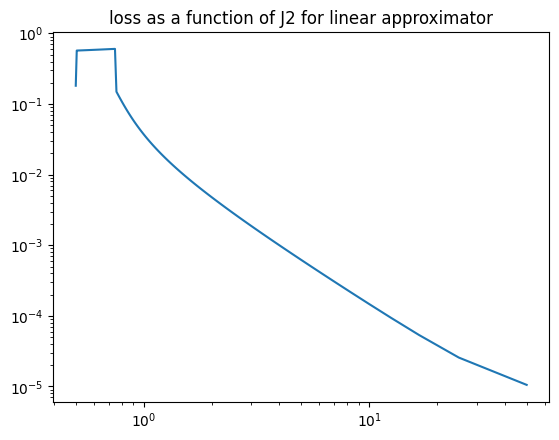

In [187]:
plt.plot(J2s, losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.title('loss as a function of J2 for linear approximator')
plt.show()

In [188]:
all_params[1][0][0][0]

tensor(0.3686)

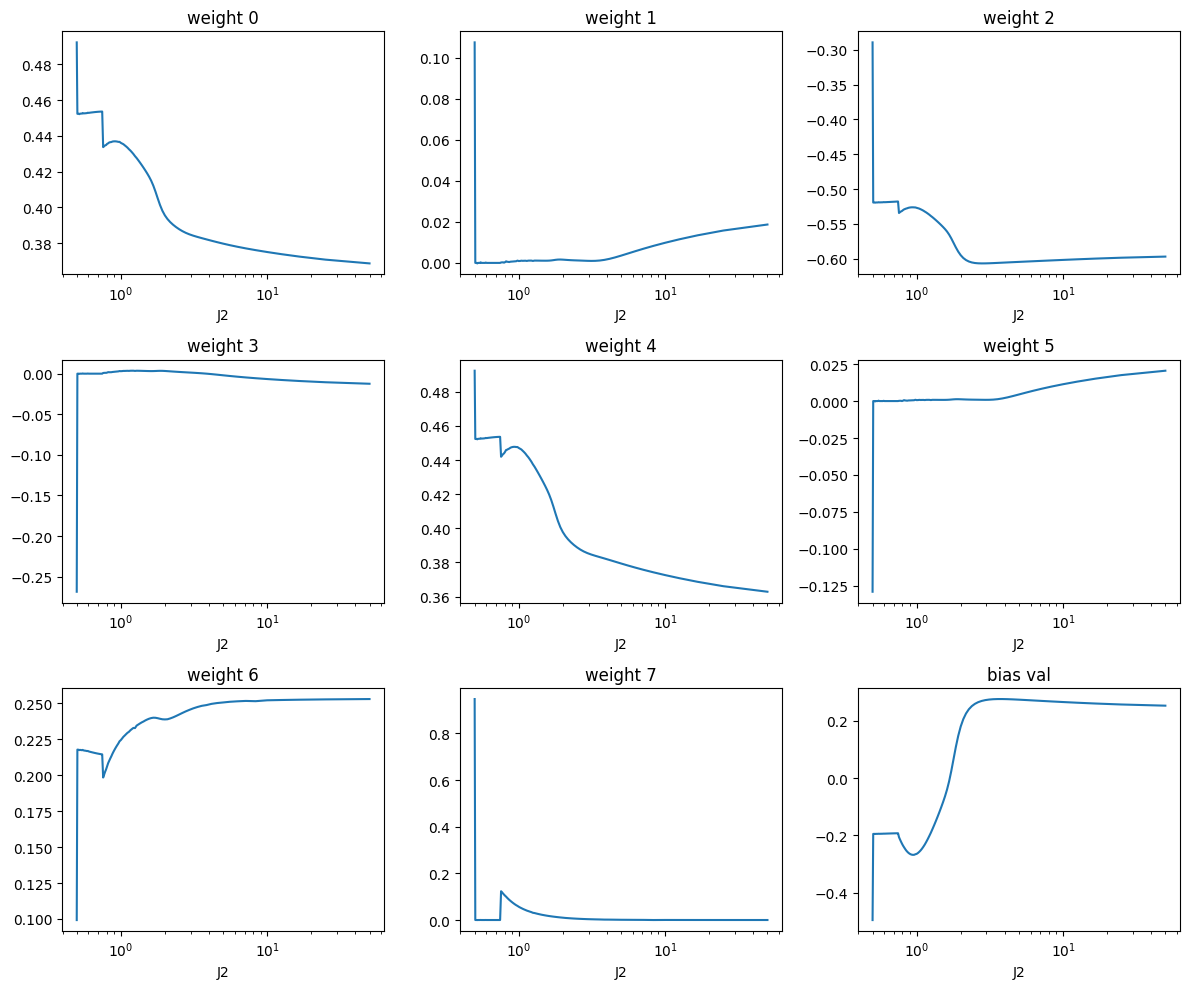

In [189]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

# Plot each weight
for i in range(8):
    param_vals = [all_params[1 + j][0][0][i].item() for j in range(len(J2s))]
    axes[i].plot(J2s, param_vals)
    axes[i].set_xscale('log')
    axes[i].set_xlabel('J2')
    axes[i].set_title(f'weight {i}')

# Plot bias
bias_vals = [all_params[1 + j][1][0].item() for j in range(len(J2s))]
axes[8].plot(J2s, bias_vals)
axes[8].set_xscale('log')
axes[8].set_xlabel('J2')
axes[8].set_title('bias val')

# Hide any extra empty subplots (if the grid has more than 9)
for k in range(9, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

In [241]:
crit_weights = [0, 2, 4, 6]

In [242]:
print(ft_input.shape)
crit_input = ft_input[:, crit_weights]
print(crit_input.shape)

torch.Size([256, 8])
torch.Size([256, 4])


In [243]:
torch.manual_seed(0)
crit_linear = nn.Sequential(nn.Linear(len(crit_weights), 1))
crit_opt = torch.optim.Adam(crit_linear.parameters(), lr=0.01, weight_decay=0)
floss = generate_loss(gs_inf, all=True)
epochs = 10000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        crit_opt.zero_grad()
        pred = torch.cos(crit_linear(crit_input))
        loss = torch.min(floss(pred, signs_inf), floss(pred, -1 * signs_inf))
        loss.backward()
        return loss
    loss = crit_opt.step(closure)
    if i % datarate == 0:
        print(loss.item())

0.8100099437870089
9.146438363435058e-06
4.670287226973516e-06
1.448504791470542e-06
2.964258038041913e-07


In [244]:
print(generate_loss(gs_inf, all=True)(torch.cos(crit_linear(crit_input)), signs_inf).item())

4.774201222011875e-08


In [245]:
crit_params = [[n.detach().clone() for n in crit_linear.parameters()]]
crit_losses = [generate_loss(gs_inf, all=True)(torch.cos(crit_linear(crit_input)), signs_inf).item()]
for J2 in J2s:
    print('J2', J2)
    gs = qt.qload(f'../J1J2_info/large_J2/N{N}/n{N}gs_J2_{round(J2, 4)}')
    states, signs = get_nonzero_states(N, gs, 0)
    floss = generate_loss(gs, all=True)
    epochs = 200; datarate = epochs // 5

    for i in range(epochs):
        def closure():
            crit_opt.zero_grad()
            pred = torch.cos(crit_linear(crit_input))
            loss = torch.min(floss(pred, signs_inf), floss(pred, -1 * signs_inf))
            loss.backward()
            return loss
        loss = crit_opt.step(closure)
        #if i % datarate == 0:
        #    print(loss.item())
    
    crit_params.append([n.detach().clone() for n in crit_linear.parameters()])
    pred = torch.cos(crit_linear(crit_input))
    crit_losses.append(torch.min(floss(pred, signs_inf), floss(pred, -1 * signs_inf)).item())
    #print()

J2 50.0
J2 25.0
J2 16.666666666666668
J2 12.5
J2 10.0
J2 8.333333333333332
J2 7.142857142857143
J2 6.25
J2 5.555555555555555
J2 5.0
J2 4.545454545454546
J2 4.166666666666667
J2 3.846153846153846
J2 3.571428571428571
J2 3.333333333333333
J2 3.125
J2 2.941176470588235
J2 2.7777777777777772
J2 2.6315789473684212
J2 2.5
J2 2.380952380952381
J2 2.272727272727273
J2 2.1739130434782608
J2 2.083333333333333
J2 2.0
J2 1.923076923076923
J2 1.8518518518518516
J2 1.7857142857142856
J2 1.7241379310344827
J2 1.6666666666666667
J2 1.6129032258064517
J2 1.5625
J2 1.5151515151515151
J2 1.4705882352941175
J2 1.4285714285714284
J2 1.3888888888888886
J2 1.3513513513513513
J2 1.3157894736842106
J2 1.282051282051282
J2 1.25
J2 1.2195121951219512
J2 1.1904761904761905
J2 1.1627906976744187
J2 1.1363636363636365
J2 1.1111111111111112
J2 1.0869565217391304
J2 1.0638297872340425
J2 1.0416666666666665
J2 1.0204081632653061
J2 1.0
J2 0.9803921568627451
J2 0.9615384615384615
J2 0.9433962264150942
J2 0.925925925925

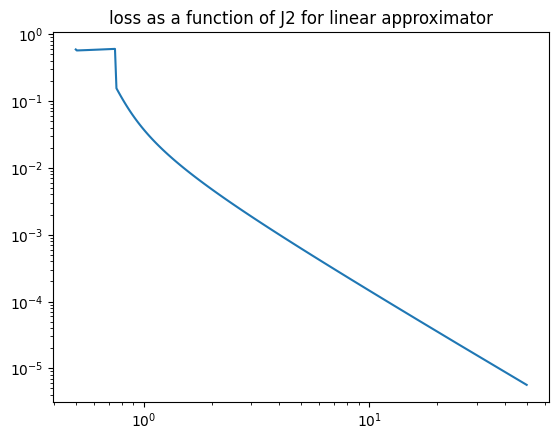

In [246]:
plt.plot(J2s, crit_losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.title('loss as a function of J2 for linear approximator')
plt.show()

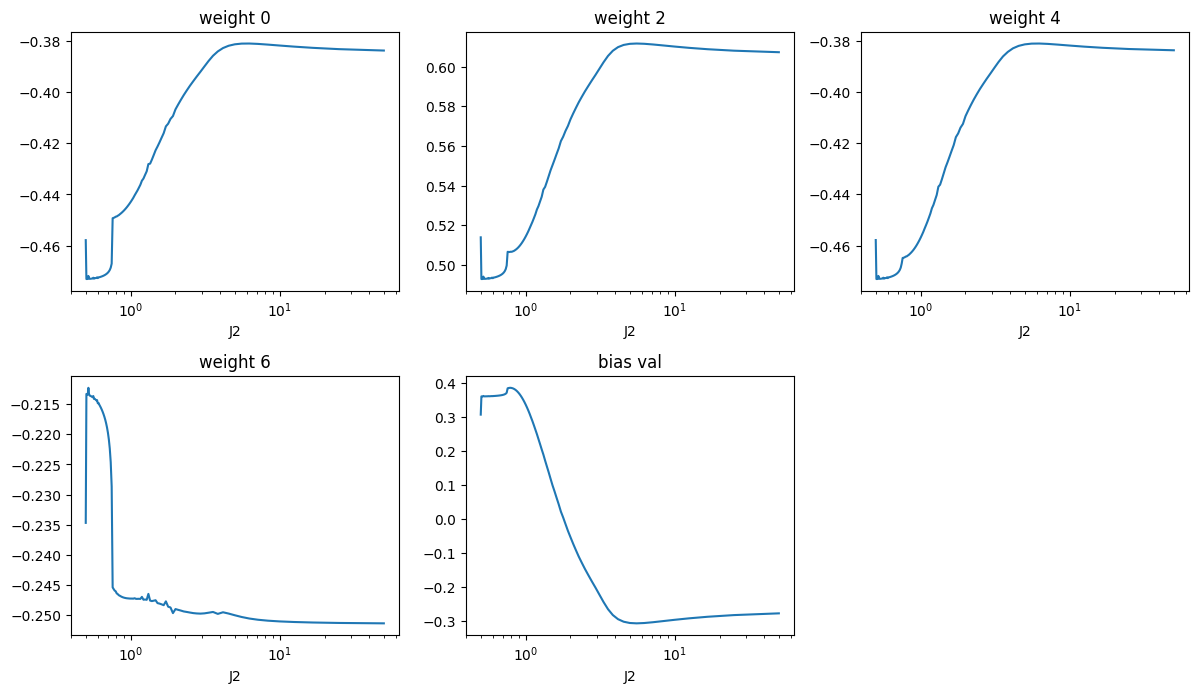

In [247]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

# Plot each weight
for i in range(len(crit_weights)):
    param_vals = [crit_params[1 + j][0][0][i].item() for j in range(len(J2s))]
    axes[i].plot(J2s, param_vals)
    axes[i].set_xscale('log')
    axes[i].set_xlabel('J2')
    axes[i].set_title(f'weight {crit_weights[i]}')

# Plot bias
bias_vals = [crit_params[1 + j][1][0].item() for j in range(len(J2s))]
axes[len(crit_weights)].plot(J2s, bias_vals)
axes[len(crit_weights)].set_xscale('log')
axes[len(crit_weights)].set_xlabel('J2')
axes[len(crit_weights)].set_title('bias val')

# Hide any extra empty subplots (if the grid has more than 9)
for k in range(len(crit_weights) + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

In [249]:
j1j2_functions.J1J2_hamiltonian(8, 0, 1).eigenstates()[0]

array([-1.60000000e+01, -1.20000000e+01, -1.20000000e+01, -1.20000000e+01,
       -1.20000000e+01, -1.20000000e+01, -1.20000000e+01, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -4.00000000e+00, -4.00000000e+00,
       -4.00000000e+00, -4.00000000e+00, -4.00000000e+00, -4.00000000e+00,
       -4.00000000e+00, -4.00000000e+00, -4.00000000e+00, -4.00000000e+00,
       -4.00000000e+00, -4.00000000e+00, -4.00000000e+00, -4.00000000e+00,
       -4.00000000e+00, -4.00000000e+00, -4.00000000e+00, -4.00000000e+00,
       -4.00000000e+00, -4.00000000e+00, -4.00000000e+00, -4.00000000e+00,
       -4.00000000e+00, -

In [251]:
gs_inf.dag() @ j1j2_functions.J1J2_hamiltonian(8, 0, 1) @ gs_inf

(-16.000000000000004+0j)

In [ ]:
gs_inf.full() * np.array([[1] if n % 2 == 0 else [-1] for n in range(2 ** 8)])

array([[ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [-9.22768213e-19+0.j],
       [ 2.32865531e-18+0.j],
       [ 8.85508948e-18+0.j],
       [-2.25389373e-17+0.j],
       [-1.02627912e-17+0.j],
       [-9.45584162e-17+0.j],
       [-3.18031524e-17+0.j],
       [ 7.31122256e-17+0.j],
       [-5.32528117e-17+0.j],
       [ 1.05640368e-16+0.j],
       [ 2.33423335e-18+0.j],
       [ 1.25127254e-16+0.j],
       [-2.31998222e-16+0.j],
       [-8.33333333e-02+0.j],
       [ 0.00000000e+00+0.j],
       [ 3.46944695e-17+0.j],
       [ 8.67361738e-18+0.j],
       [-9.36750677e-17+0.j],
       [ 1.73472348e-17+0.j],
       [ 0.00000000e+00+0.j],
       [ 6.63531730e-17+0.j],
       [-3.33066907e-16+0.j],
       [ 4.40186082e-17+0.j],
       [ 1.82145965e-17+0.j],
       [ 1.78025997e-16+0.j],
       [ 1.66666667e-01+0.j],
       [-4.74880552e-17+0.j],
       [ 4.50130041e-17+0.j],
       [-8.33333333e-02+0.j],
       [-2.73691106e-47+0.j],
       [ 1.30104261e-18+0.j],
       [ 7